HOW TO CHECK YOUR MODEL

Fetch dataset.

In [1]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()
print(iris_dataset["DESCR"])
print(iris_dataset['target_names'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

Split the data.

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris_dataset['data'], iris_dataset['target'], random_state=42)

Turn into binary classification.

In [3]:
y_train_setosa = (y_train == 0)
y_test_setosa = (y_test == 0)

print(f"y_train_setosa:\n{y_train_setosa}")
print(f"y_test_setosa:\n{y_test_setosa}")

y_train_setosa:
[ True  True False False False  True  True False False False False False
 False False False  True False False  True  True  True False False  True
  True  True False  True False False  True False False  True False False
 False False False False  True False False  True  True False False  True
 False  True  True False False False False False False False  True  True
 False False  True  True  True False False  True False False  True False
 False False False False  True False False False False False False  True
 False False  True False False False  True False False False  True False
  True False False False False False False False False False  True False
 False  True False False]
y_test_setosa:
[False  True False False False  True False False False False False  True
  True  True  True False False False False False  True False  True False
 False False False False  True  True  True  True False  True  True False
 False  True]


Train the models.

In [4]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(C=1, solver='lbfgs')
sv_clf = SVC(max_iter=10000, probability=True)

lr_clf.fit(X_train, y_train_setosa)
sv_clf.fit(X_train, y_train_setosa)

SVC(max_iter=10000, probability=True)

Do some predictions.

In [22]:
some_flower = X_train[0]    # True
other_flower = X_train[2]   # False
lr_clf.predict([some_flower])

array([ True])

Get the probability predictions.

In [6]:
lr_probas = lr_clf.predict_proba(X_test)[:, 1]

sv_preds = sv_clf.predict_proba(X_test)
sv_probas = sv_clf.decision_function(X_test)
sv_probas = (sv_probas - sv_probas.min()) / (sv_probas.max() - sv_probas.min())

Plot the AUC-ROC graph for the two classifiers.

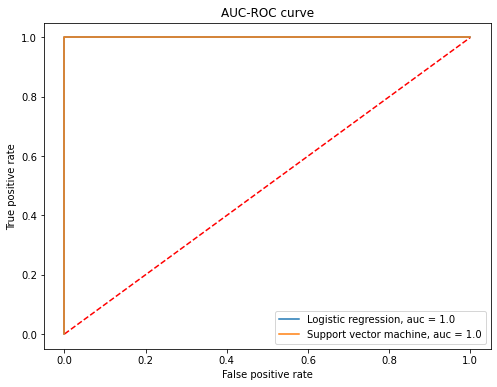

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics

plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], "r--")

pred = lr_probas
label = y_test_setosa
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f"Logistic regression, auc = {str(round(auc, 3))}")

pred = sv_probas
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr, tpr, label=f"Support vector machine, auc = {str(round(auc, 3))}")

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("AUC-ROC curve")
plt.legend()
plt.show()

Do some tests.

In [8]:
# Accuracy

from sklearn.model_selection import cross_val_score
lr_cvs = cross_val_score(lr_clf, X_test, y_test_setosa, cv=3, scoring="accuracy")
sv_cvs = cross_val_score(sv_clf, X_test, y_test_setosa, cv=3, scoring="accuracy")

print(f"Logistic regression score: {lr_cvs}")
print(f"Support vector machine score: {sv_cvs}")

Logistic regression score: [1. 1. 1.]
Support vector machine score: [1. 1. 1.]


In [9]:
# Precision vs. recall

from sklearn.metrics import precision_score, recall_score

y_test_pred = sv_clf.predict(X_test)
sv_prec = precision_score(y_test_setosa, y_test_pred)
sv_recall = recall_score(y_test_setosa, y_test_pred)

print("SVM precision score: ", sv_prec)
print("SVM recall score: ", sv_recall)

y_test_pred = lr_clf.predict(X_test)
lr_prec = precision_score(y_test_setosa, y_test_pred)
lr_recall = precision_score(y_test_setosa, y_test_pred)

print("LR precision score: ", lr_prec)
print("LR recall score: ", lr_recall)

SVM precision score:  1.0
SVM recall score:  1.0
LR precision score:  1.0
LR recall score:  1.0


Make a function to plot the calibration curve

In [10]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(name, fig_index, probs):

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    frac_of_pos, mean_pred_value = calibration_curve(y_test_setosa, probs, n_bins=10)

    ax1.plot(mean_pred_value, frac_of_pos, "s-", label=f'{name}')
    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title(f'Calibration plot ({name})')
    
    ax2.hist(probs, range=(0, 1), bins=10, label=name, histtype="step", lw=2)
    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")

Plot the curve for the logistic regression model.

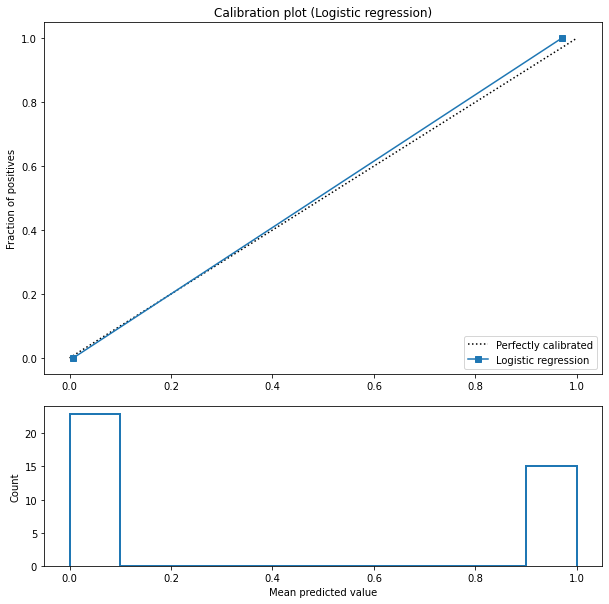

In [11]:
plot_calibration_curve("Logistic regression", 1, lr_probas)

Plot the calibration curve for the SVM model.

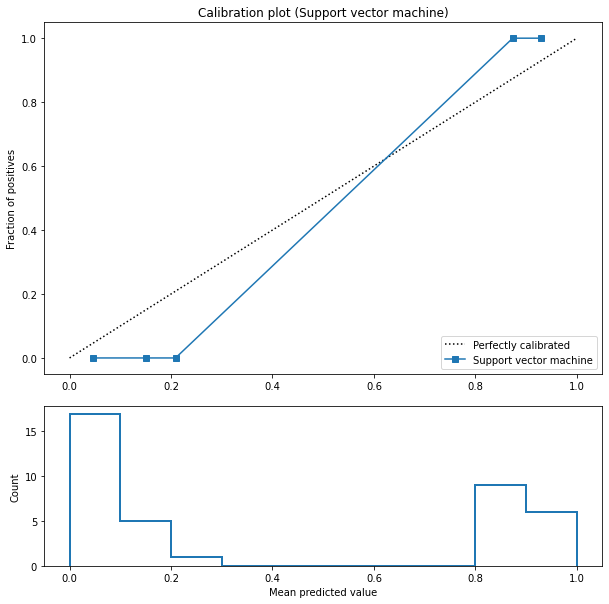

In [12]:
plot_calibration_curve("Support vector machine", 1, sv_probas)

CALIBRATING THE MODEL

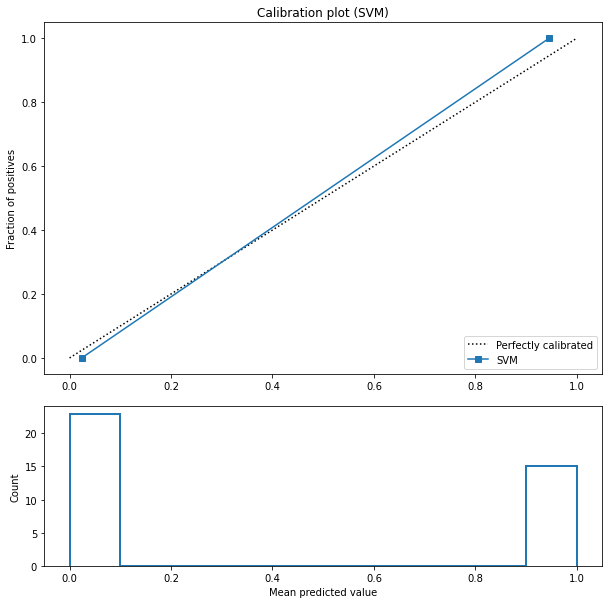

In [13]:
from sklearn.calibration import CalibratedClassifierCV

sv_clf = SVC(max_iter=10000, probability=True)

platts_scaling = CalibratedClassifierCV(sv_clf, cv=2, method="sigmoid")
platts_scaling.fit(X_train, y_train_setosa)
calibrated_probas = platts_scaling.predict_proba(X_test)[:, 1]

plot_calibration_curve("SVM", 1, calibrated_probas)

AFTER CALIBRATION...

In [14]:
# Accuracy tests
sv_cvs = cross_val_score(platts_scaling, X_test, y_test_setosa, cv=3, scoring="accuracy")
print(f"SVM score: {sv_cvs}")

SVM score: [1. 1. 1.]


In [15]:
# Precision vs. recall

y_test_pred = platts_scaling.predict(X_test)
sv_prec = precision_score(y_test_setosa, y_test_pred)
sv_recall = recall_score(y_test_setosa, y_test_pred)

print("SVM precision score: ", sv_prec)
print("SVM recall score: ", sv_recall)

SVM precision score:  1.0
SVM recall score:  1.0


BETA CALIBRATION

(38, 2)
(38,)


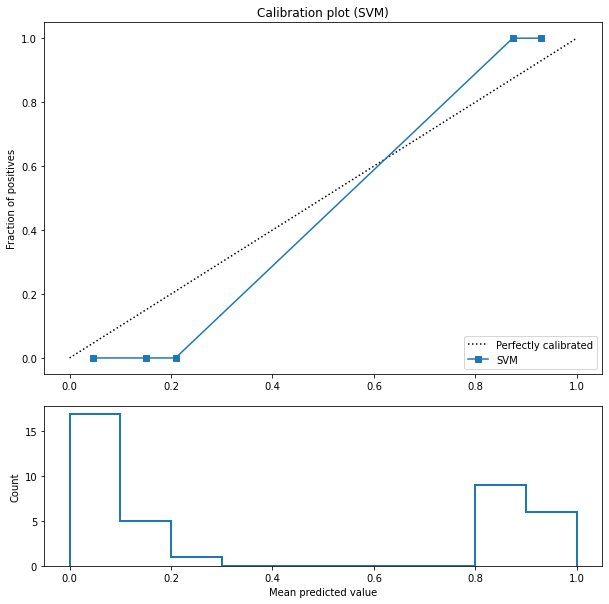

In [16]:
sv_clf = SVC(max_iter=10000, probability=True)
sv_clf.fit(X_train, y_train_setosa)
sv_preds = sv_clf.predict_proba(X_test)
sv_probas = sv_clf.decision_function(X_test)
sv_probas = (sv_probas - sv_probas.min()) / (sv_probas.max() - sv_probas.min())
plot_calibration_curve("SVM", 1, sv_probas)
print(sv_preds.shape)
print(sv_probas.shape)

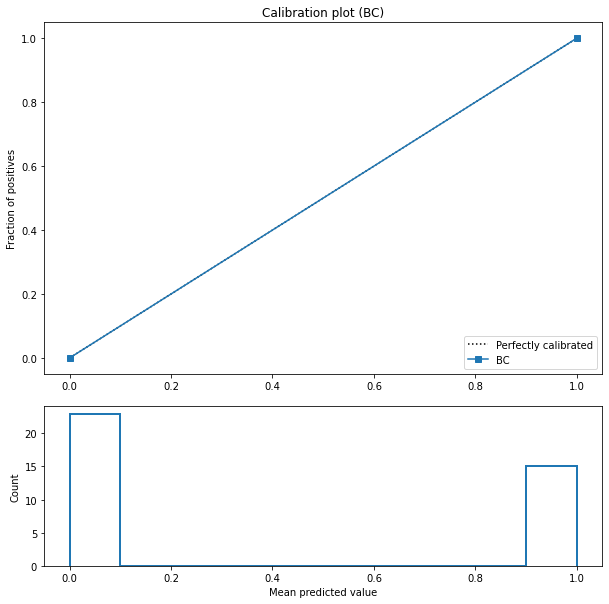

In [17]:
from betacal import BetaCalibration

sv_preds2 = sv_clf.predict_proba(X_train)
sv_probas2 = sv_clf.decision_function(X_train)
sv_probas2 = (sv_probas2 - sv_probas2.min()) / (sv_probas2.max() - sv_probas2.min())

bc = BetaCalibration(parameters="abm")
bc.fit(sv_probas2, y_train_setosa)
cal_probas = bc.predict(sv_probas)
plot_calibration_curve("BC", 1, cal_probas)